## Importing Required Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

## Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


## Path

In [3]:
base_path = "/kaggle/input/caltech-101/caltech-101/101_ObjectCategories/101_ObjectCategories"


## Random Images Visualization

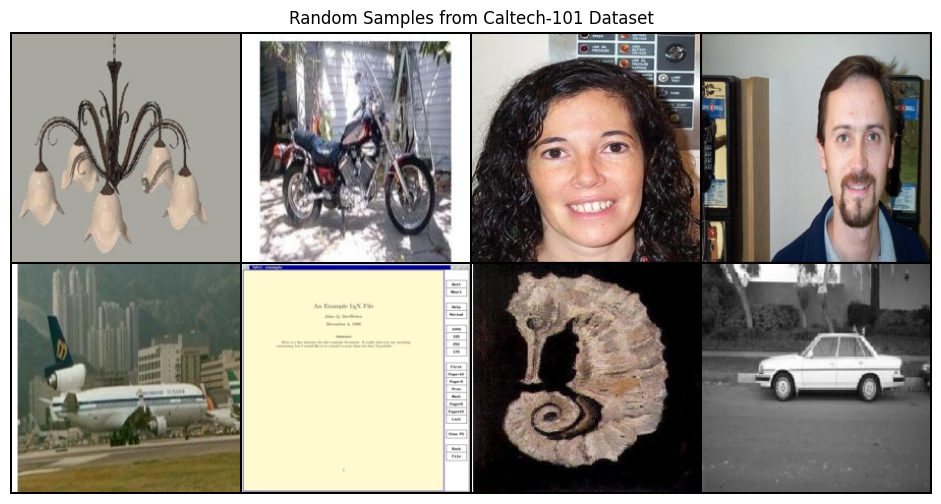

Labels: ['chandelier', 'Motorbikes', 'Faces_easy', 'Faces', 'airplanes', 'BACKGROUND_Google', 'sea_horse', 'car_side']


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Load dataset only once
from torchvision import datasets, transforms


transform_vis = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_vis = datasets.ImageFolder(base_path, transform=transform_vis)

# Random sample image grid
def visualize_samples():
    indices = np.random.choice(len(dataset_vis), 8, replace=False)
    images = [dataset_vis[i][0] for i in indices]
    labels = [dataset_vis.classes[dataset_vis[i][1]] for i in indices]

    grid = make_grid(images, nrow=4)
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.title("Random Samples from Caltech-101 Dataset")
    plt.axis("off")
    plt.show()

    print("Labels:", labels)

visualize_samples()


## Class Distribution Chart

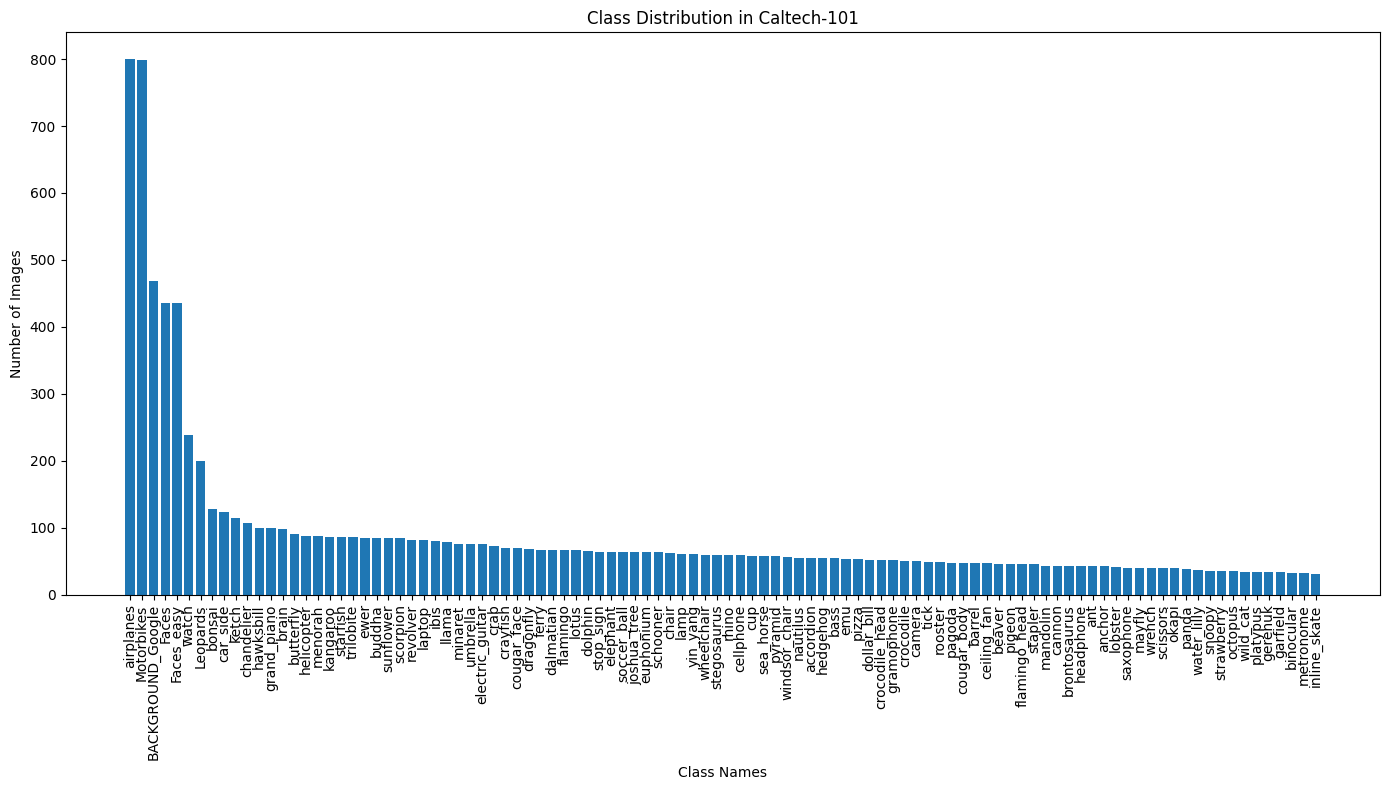

In [5]:
import os
import matplotlib.pyplot as plt

class_counts = {}

for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort classes by count
sorted_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(14, 8))
plt.bar(sorted_counts.keys(), sorted_counts.values())
plt.xticks(rotation=90)
plt.title("Class Distribution in Caltech-101")
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


## New Preprocessing Pipeline

## Data Augmentation + Preprocessing

In [6]:
import cv2
import numpy as np
from PIL import Image

class GammaCLAHETransform:
    def __init__(self, gamma_dark=0.7, gamma_bright=1.3, clipLimit=3.0, tileGridSize=(8,8)):
        self.gamma_dark = gamma_dark
        self.gamma_bright = gamma_bright
        self.clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)

    def __call__(self, img):
        img = np.array(img)

        # Convert to LAB for brightness decision
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        L = lab[:,:,0]

        mean_light = np.mean(L)

        # Decide gamma based on brightness level
        if mean_light < 100:
            gamma = self.gamma_dark  # brighten
        else:
            gamma = self.gamma_bright # darken

        # Apply Gamma Correction
        img_float = img / 255.0
        img_gamma = np.power(img_float, gamma)
        img_gamma = (img_gamma * 255).astype(np.uint8)

        # Apply Advanced CLAHE to L channel only
        lab_gamma = cv2.cvtColor(img_gamma, cv2.COLOR_RGB2LAB)
        lab_gamma[:,:,0] = self.clahe.apply(lab_gamma[:,:,0])
        final_img = cv2.cvtColor(lab_gamma, cv2.COLOR_LAB2RGB)

        return Image.fromarray(final_img)


In [10]:
from torchvision import transforms

advanced_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    GammaCLAHETransform(),   
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_advanced_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

def apply_gamma(img, gamma):
    img = np.array(img) / 255.0
    img = np.power(img, gamma)
    return Image.fromarray((img * 255).astype(np.uint8))

def apply_clahe(img):
    img = np.array(img)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    final = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return Image.fromarray(final)

def apply_gamma_clahe(img):
    return GammaCLAHETransform()(img)

def show_images(images, titles, figsize=(16,8)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.show()


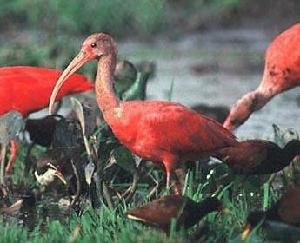

In [13]:
from random import choice
import os

sample_class = choice(os.listdir(base_path))
sample_path = base_path + "/" + sample_class
sample_image_file = choice(os.listdir(sample_path))
sample_image = Image.open(sample_path + "/" + sample_image_file).convert("RGB")

sample_image


## BEFORE vs AFTER (Gamma + ACCLAHE)

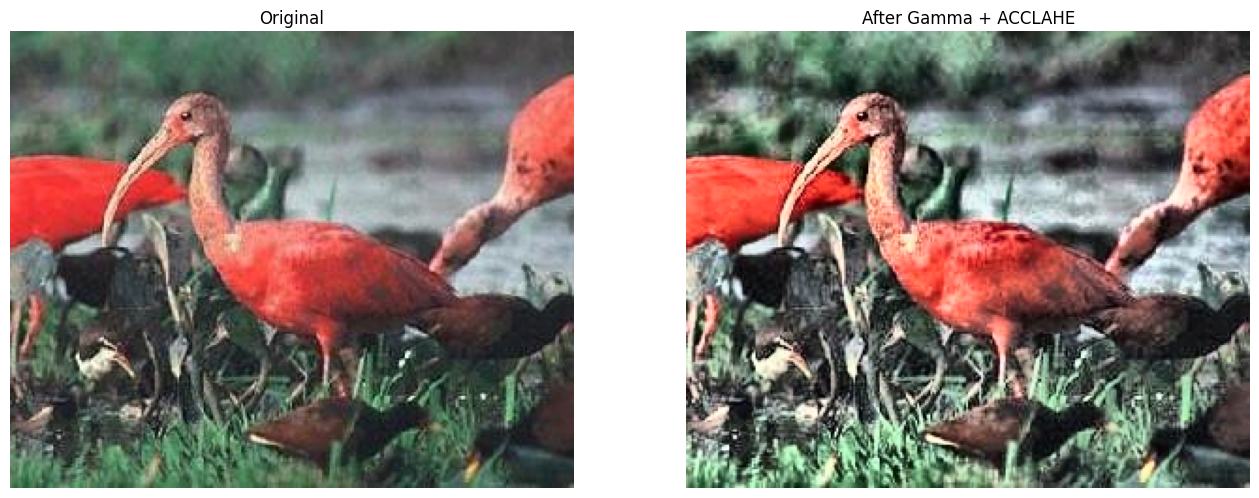

In [14]:
processed = apply_gamma_clahe(sample_image)

show_images(
    [sample_image, processed],
    ["Original", "After Gamma + ACCLAHE"],
)


## Gamma-only vs CLAHE-only vs Combined

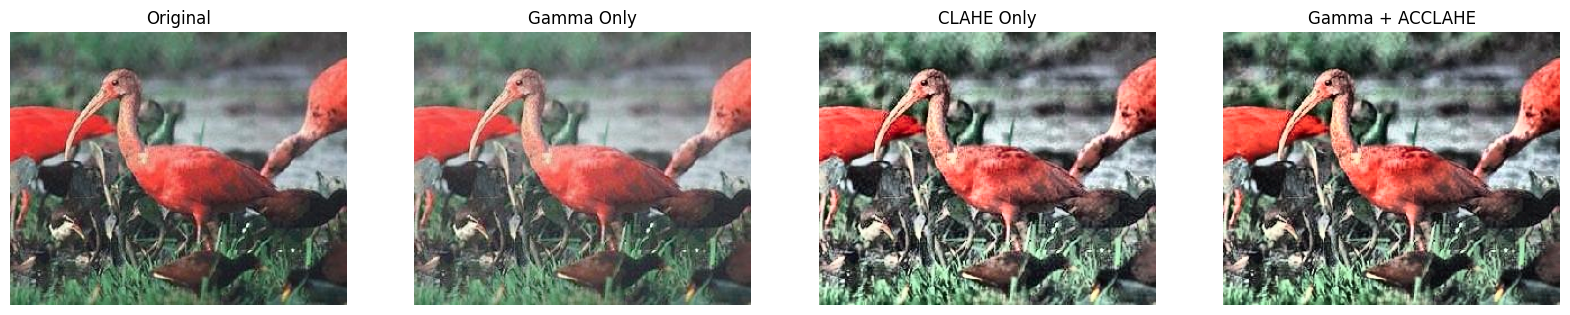

In [15]:
gamma_img = apply_gamma(sample_image, 0.8)
clahe_img = apply_clahe(sample_image)
combined_img = apply_gamma_clahe(sample_image)

show_images(
    [sample_image, gamma_img, clahe_img, combined_img],
    ["Original", "Gamma Only", "CLAHE Only", "Gamma + ACCLAHE"],
    figsize=(20,6)
)


## Histogram Equalization Analysis

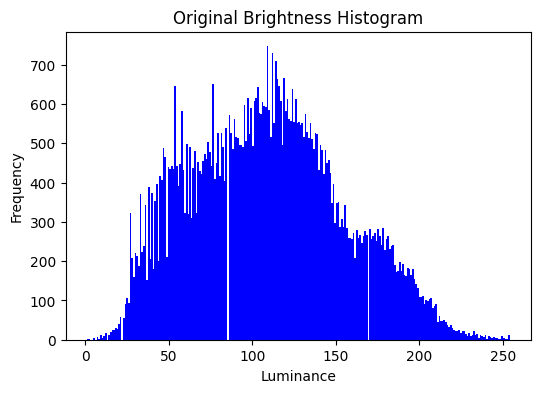

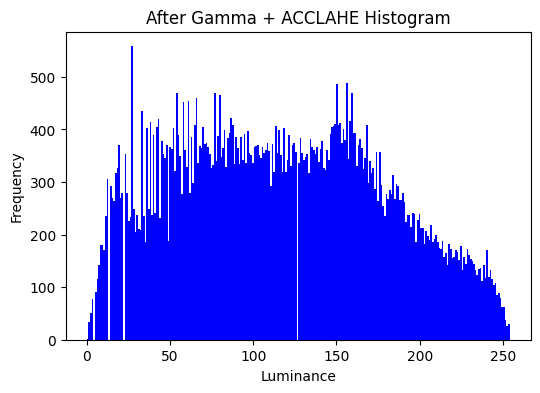

In [16]:
def plot_histogram(img, title):
    img_np = np.array(img)
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]

    plt.figure(figsize=(6,4))
    plt.hist(L.flatten(), bins=256, color='blue')
    plt.title(title)
    plt.xlabel("Luminance")
    plt.ylabel("Frequency")
    plt.show()

# Original histogram
plot_histogram(sample_image, "Original Brightness Histogram")

# After CLAHE histogram
after = apply_gamma_clahe(sample_image)
plot_histogram(after, "After Gamma + ACCLAHE Histogram")


## Train Test Split

In [ ]:
from torchvision import datasets, transforms
from PIL import Image
import random
dataset_adv = datasets.ImageFolder(base_path, transform=advanced_transform)

train_size = int(0.8 * len(dataset_adv))
test_size = len(dataset_adv) - train_size
train_data, test_data = random_split(dataset_adv, [train_size, test_size])
test_data.dataset.transform = test_advanced_transform

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print("train_size", train_size)
print("test_size" , test_size)

num_classes = len(dataset_adv.classes)
print("Classes:", num_classes)

## GoogLeNet Model

In [21]:
model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)  
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [23]:
from tqdm import tqdm  

epochs = 10
best_accuracy = 0
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    print(f"\n Training Epoch {epoch+1}/{epochs}")
    
    # tqdm progress bar for training batches
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f" Avg Loss: {avg_loss:.4f} — Validating...")

    # Validation Accuracy
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            _, predicted = preds.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    test_accuracies.append(acc)
    
    print(f" Epoch [{epoch+1}/{epochs}] — Loss: {avg_loss:.4f} | Test Accuracy: {acc:.2f}%")

    if acc > best_accuracy:
        best_accuracy = acc
        torch.save(model.state_dict(), "best_googlenet.pth")
        print(" Best model updated & saved!")

print("\n Training Completed Successfully!")
print(f"Best Test Accuracy Achieved: {best_accuracy:.2f}% 🚀")



 Training Epoch 1/10


 Avg Loss: 2.4617 — Validating...


 Epoch [1/10] — Loss: 2.4617 | Test Accuracy: 76.98%
 Best model updated & saved!

 Training Epoch 2/10


 Avg Loss: 0.8428 — Validating...


 Epoch [2/10] — Loss: 0.8428 | Test Accuracy: 92.18%
 Best model updated & saved!

 Training Epoch 3/10


 Avg Loss: 0.3037 — Validating...


 Epoch [3/10] — Loss: 0.3037 | Test Accuracy: 94.70%
 Best model updated & saved!

 Training Epoch 4/10


 Avg Loss: 0.1504 — Validating...


 Epoch [4/10] — Loss: 0.1504 | Test Accuracy: 94.97%
 Best model updated & saved!

 Training Epoch 5/10


 Avg Loss: 0.1307 — Validating...


 Epoch [5/10] — Loss: 0.1307 | Test Accuracy: 95.02%
 Best model updated & saved!

 Training Epoch 6/10


 Avg Loss: 0.1162 — Validating...


 Epoch [6/10] — Loss: 0.1162 | Test Accuracy: 95.41%
 Best model updated & saved!

 Training Epoch 7/10


 Avg Loss: 0.1099 — Validating...


 Epoch [7/10] — Loss: 0.1099 | Test Accuracy: 95.30%

 Training Epoch 8/10


 Avg Loss: 0.1061 — Validating...


 Epoch [8/10] — Loss: 0.1061 | Test Accuracy: 95.30%

 Training Epoch 9/10


 Avg Loss: 0.1052 — Validating...


 Epoch [9/10] — Loss: 0.1052 | Test Accuracy: 95.30%

 Training Epoch 10/10


 Avg Loss: 0.1043 — Validating...


 Epoch [10/10] — Loss: 0.1043 | Test Accuracy: 95.19%

 Training Completed Successfully!
Best Test Accuracy Achieved: 95.41% 🚀


## Confusion Matrix + Classification Report

In [25]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)


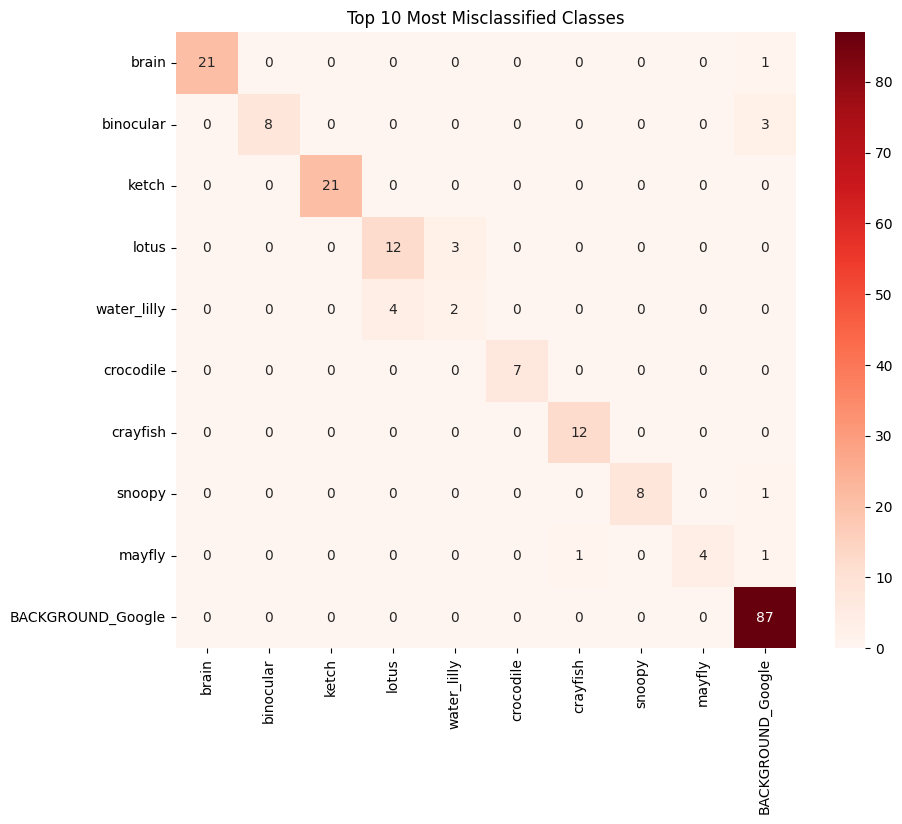

In [28]:
errors = np.sum(cm, axis=1) - np.diag(cm)
top_mis = np.argsort(errors)[-10:]  # Top 10 most confused classes

plt.figure(figsize=(10, 8))
sns.heatmap(cm[np.ix_(top_mis, top_mis)],
            xticklabels=np.array(dataset_adv.classes)[top_mis],
            yticklabels=np.array(dataset_adv.classes)[top_mis],
            annot=True,
            cmap="Reds")
plt.title("Top 10 Most Misclassified Classes")
plt.show()


## Plot Loss & Accuracy Curves

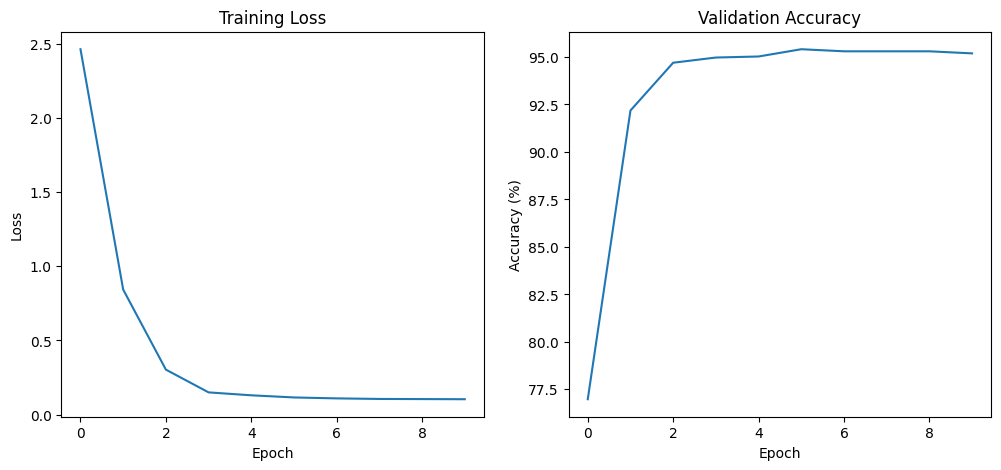

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(test_accuracies)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()

## Show Predictions on some test images

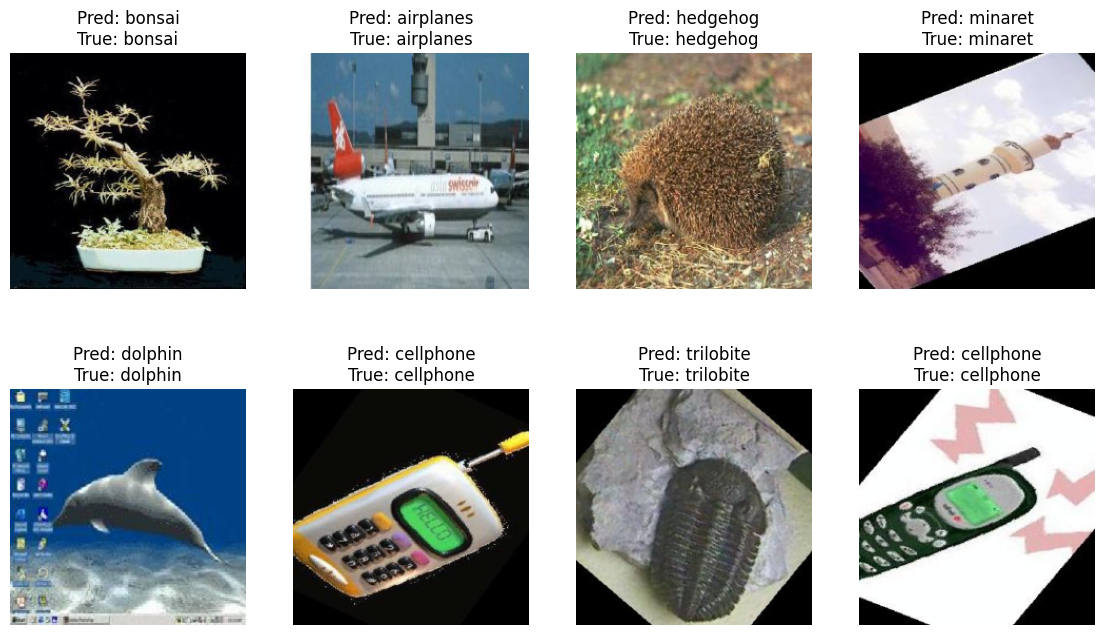

In [31]:
def show_predictions():
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = outputs.max(1)
    
    plt.figure(figsize=(14, 8))
    for i in range(8):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {dataset_adv.classes[preds[i]]}\nTrue: {dataset_adv.classes[labels[i]]}")
        plt.axis('off')

    plt.show()

show_predictions()